In [1]:
import numpy as np
from scipy import stats

np.random.seed(2021)

In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.rcParams['axes.xmargin'] = 0
mpl.rcParams['axes.titlesize'] = 24
mpl.rcParams['legend.fontsize'] = 14
mpl.rcParams['xtick.labelsize'] = 12
mpl.rcParams['ytick.labelsize'] = 12
mpl.rcParams['lines.markersize'] = 8
mpl.rcParams['legend.frameon'] = False

mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.family'] = 'sans-serif'

---

In [3]:
num_classes = 3

p_z = np.array([.4, .35, .25])
mean = np.array([-6.5, -1.5, 4])
std = np.array([1.2, 1.4, 1.6])

In [4]:
def probs(x):
    # [num_points, num_classes]
    p_x_z = np.stack([stats.norm(mean[i], std[i]).pdf(x) 
                      for i in range(num_classes)], -1)
    # [num_points, num_classes]
    p_xz = p_x_z * p_z
    # [num_points]
    p_x = p_xz.sum(1)
    # [num_points, num_classes]
    p_z_x = p_xz / p_x[:, None]
    return p_xz, p_x, p_z_x

In [5]:
x_range = [-10, 10]
x_lin = np.linspace(*x_range, 100)
p_xz_lin, p_x_lin, p_z_x_lin = probs(x_lin)

In [6]:
num_points = 200
z = np.random.randint(0, num_classes, (num_points,))
x = mean[z] + std[z] * np.random.randn(num_points)
p_z_x = probs(x)[2]

In [7]:
num_flip = 15
y = np.copy(z)
y[:num_flip] = np.array(list(map(np.random.choice, 
                                 p_z_x[:num_flip].argsort(axis=1)[:, :2])))

In [8]:
c_list = ['xkcd:red', 'xkcd:green', 'xkcd:blue']
Tc = np.array(list(map(mpl.colors.to_rgb, c_list)))
c_y = [c_list[yi] for yi in y]

---

In [9]:
import torch
import torch.nn.functional as F
from torch import nn, optim
from torch.utils.data import TensorDataset, DataLoader

torch.manual_seed(2021);

In [10]:
from lio.utils.data import IndexDataset

In [11]:
x_lin_tensor = torch.tensor(x_lin[:, None]).float()
x_tensor = torch.tensor(x[:, None]).float()
y_tensor = torch.tensor(y).long()

dataset = IndexDataset(TensorDataset(x_tensor, y_tensor))
loader = DataLoader(dataset, batch_size=64, shuffle=True)
epochs = 100

In [12]:
def get_model(dim_output):
    model = nn.Sequential(
        nn.Linear(1, 256),
        nn.ReLU(inplace=True),
        nn.Linear(256, dim_output),
    )
    return model

In [13]:
model = get_model(num_classes)
optimizer = optim.Adam(model.parameters())

for epoch in range(epochs):
    for i, (x_batch, y_batch) in loader:
        optimizer.zero_grad()
        F.cross_entropy(model(x_batch), y_batch).backward()
        optimizer.step()

with torch.no_grad():
    p_z_x_1 = F.softmax(model(x_lin_tensor), dim=1)

In [14]:
model = get_model(num_classes)
optimizer = optim.Adam(model.parameters(), weight_decay=0.5)

for epoch in range(epochs):
    for i, (x_batch, y_batch) in loader:
        optimizer.zero_grad()
        F.cross_entropy(model(x_batch), y_batch).backward()
        optimizer.step()

with torch.no_grad():
    p_z_x_2 = F.softmax(model(x_lin_tensor), dim=1)

In [15]:
model = get_model(num_classes)
optimizer_model = optim.Adam(model.parameters())
embed = nn.Sequential(get_model(1), nn.Sigmoid())
optimizer_embed = optim.Adam(embed.parameters())

for epoch in range(epochs * 5):
    if epoch == epochs:
        for p in model.parameters():
            p.requires_grad = False
    for i, (x_batch, y_batch) in loader:
        optimizer_model.zero_grad()
        optimizer_embed.zero_grad()
        t = model(x_batch)
        c = embed(x_batch)
        q = c * F.softmax(t, dim=1) + (1 - c) * 1 / t.shape[1]
        F.cross_entropy(torch.log(q), y_batch).backward()
        optimizer_model.step()
        optimizer_embed.step()

with torch.no_grad():
    p_z_x_3 = F.softmax(model(x_lin_tensor), dim=1)
    confidence_3 = embed(x_lin_tensor).numpy().squeeze()

In [16]:
from core import (
    get_embedding, get_train_step,
    linear_interpolation,
)

In [17]:
model = get_model(num_classes)
optimizer_model = optim.Adam(model.parameters())
embed = get_embedding(num_points)
optimizer_embed = optim.SGD(embed.parameters(), lr=1e2)
train_step = get_train_step(model, optimizer_model, 
                            embed, optimizer_embed,
                            linear_interpolation)

for epoch in range(epochs):
    for i, (x_batch, y_batch) in loader:
        train_step(i, x_batch, y_batch)

with torch.no_grad():
    p_z_x_4 = F.softmax(model(x_lin_tensor), dim=1)
    indices = torch.arange(num_points).long()
    confidence_4 = embed(indices).numpy().squeeze()

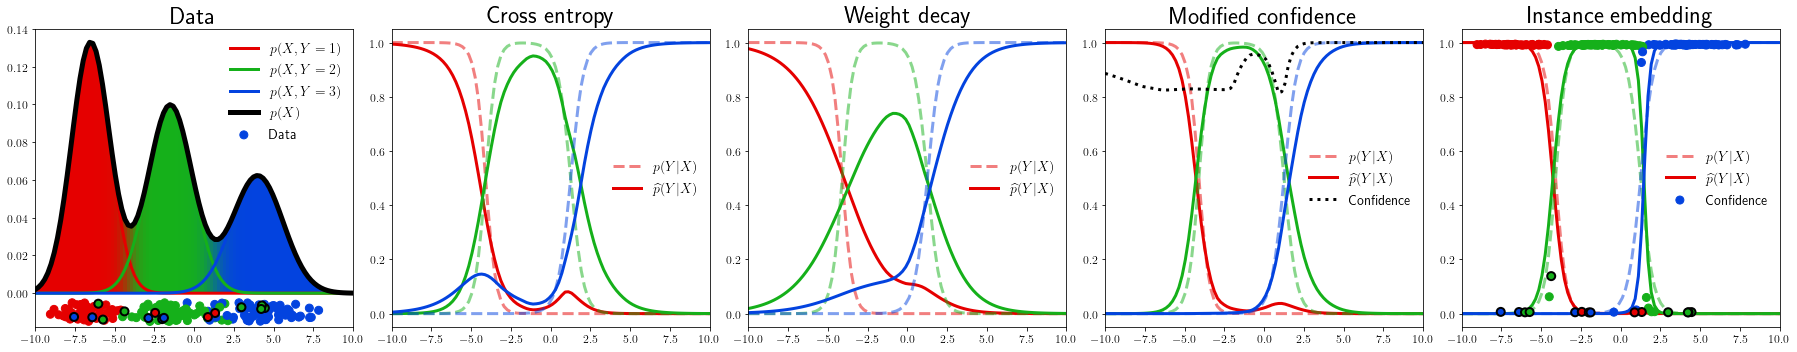

In [18]:
fig, axes = plt.subplots(ncols=5, figsize=(25, 5))

ax = axes[0]
ax.set_title('Data')
ax.set_xlim(x_range)
ax.set_ylim([-0.018, 0.14])

ax.bar(x_lin, p_x_lin,
       width=(x_lin[1] - x_lin[0]),
       color=p_z_x_lin @ Tc)

for i, c in enumerate(c_list):
    ax.plot(x_lin, p_xz_lin[:, i],
            label=f'$p(X, Y={i + 1})$',
            c=c, linewidth=3)

ax.plot(x_lin, p_x_lin,
        label='$p(X)$',
        color='k', linewidth=5)

ax.scatter(x[num_flip:], np.random.uniform(-0.015, -0.005, (len(x) - num_flip,)),
           label='Data',
           color=c_y[num_flip:])
ax.scatter(x[:num_flip], np.random.uniform(-0.015, -0.005, (num_flip,)),
           color=c_y[:num_flip],
           edgecolor='k', linewidth=2);

ax.legend()

# --------------------------------------------------------------------

ax = axes[1]
ax.set_title('Cross entropy')

for i, c in enumerate(c_list):
    ax.plot(x_lin, p_z_x_lin[:, i],
            label='$p(Y | X)$' if i == 0 else None,
            c=c, alpha=0.5, linewidth=3, linestyle='dashed')
    ax.plot(x_lin, p_z_x_1[:, i],
            label='$\widehat{p}(Y | X)$' if i == 0 else None,
            c=c, linewidth=3)

ax.legend()

# --------------------------------------------------------------------

ax = axes[2]
ax.set_title('Weight decay')

for i, c in enumerate(c_list):
    ax.plot(x_lin, p_z_x_lin[:, i],
            label='$p(Y | X)$' if i == 0 else None,
            c=c, alpha=0.5, linewidth=3, linestyle='dashed')
    ax.plot(x_lin, p_z_x_2[:, i],
            label='$\widehat{p}(Y | X)$' if i == 0 else None,
            c=c, linewidth=3)

ax.legend()

# --------------------------------------------------------------------

ax = axes[3]
ax.set_title('Modified confidence')

for i, c in enumerate(c_list):
    ax.plot(x_lin, p_z_x_lin[:, i],
            label='$p(Y | X)$' if i == 0 else None,
            c=c, alpha=0.5, linewidth=3, linestyle='dashed')
    ax.plot(x_lin, p_z_x_3[:, i],
            label='$\widehat{p}(Y | X)$' if i == 0 else None,
            c=c, linewidth=3)

ax.plot(x_lin, confidence_3,
        label='Confidence',
        c='k', linewidth=3, linestyle='dotted')

ax.legend()
    
# --------------------------------------------------------------------

ax = axes[4]
ax.set_title('Instance embedding')

for i, c in enumerate(c_list):
    ax.plot(x_lin, p_z_x_lin[:, i],
            label='$p(Y | X)$' if i == 0 else None,
            c=c, alpha=0.5, linewidth=3, linestyle='dashed')
    ax.plot(x_lin, p_z_x_4[:, i],
            label='$\widehat{p}(Y | X)$' if i == 0 else None,
            c=c, linewidth=3)

ax.scatter(x[num_flip:], confidence_4[num_flip:],
           label='Confidence',
           color=c_y[num_flip:],
           zorder=10)
ax.scatter(x[:num_flip], confidence_4[:num_flip],
           color=c_y[:num_flip],
           edgecolor='k', linewidth=2, 
           zorder=10)

ax.legend()

fig.tight_layout()
fig.savefig('plot/demo.pdf', dpi=100, bbox_inches='tight')